In [35]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve 
from lightkurve import KeplerLightCurve, KeplerTargetPixelFile
from k2sc.standalone import k2sc_lc
import k2sc
print(k2sc.__file__)
from astropy.table import Table
from astropy.io import fits

import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

/anaconda3/lib/python3.7/site-packages/K2SC-1.0-py3.7.egg/k2sc/__init__.py
Populating the interactive namespace from numpy and matplotlib


In [51]:
campaign = 7
ddir = '../reduced/c%d/'% campaign
starname = 'Ascella'
fname = ddir+'%s_halo_lc_o1.fits' % starname

f = fitsio.FITS(fname)
hdr = fitsio.read_header(fname)

all_stars = Table.read('../data/haloC%d.csv' % campaign,format='ascii')
star = all_stars[all_stars['Name']==starname]
epic = star['EPIC ID'].data.data[0]
star

Name,Vmag,Sp. Type,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],MASK,Investigation IDs,TPF,LC Halo Lightcurve,Lightcurve Image,Weight Image,Flux Image,Project,Contact,Publication,Comments
str9,float64,str16,int64,float64,float64,str4,str9,int64,int64,int64,int64,int64,int64,int64,int64,int64
Ascella,2.585,A2.5Va,200062593,285.65184,-29.879815,Halo,GO7081_LC,--,--,--,--,--,--,--,--,--


In [3]:
def match_cadences(halocads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in halocads])
    return np.where(indices==1)[0]



In [16]:
tpf = lightkurve.open('../data/ktwo%d-c%02d_lpd-targ.fits.gz' % (epic,campaign))
lc = tpf.to_lightcurve('aperture')
lc.pos_corr1 = tpf.pos_corr1
lc.pos_corr2 = tpf.pos_corr2
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header

inds_lc = match_cadences(lc.cadenceno,f[1]['cadence'][:])
lc = lc[inds_lc]
lc.pos_corr1 = lc.pos_corr1[inds_lc]
lc.pos_corr2 = lc.pos_corr2[inds_lc]


inds_flux = match_cadences(f[1]['cadence'][:],lc.cadenceno)
lc.flux = f[1]['corr_flux'][inds_flux]

In [17]:
# now the magic happens
lc.__class__ = k2sc_lc

In [18]:
lc.k2sc()

Using default splits [2344] for campaign 5
Starting initial outlier detection
  Flagged 541 (14.8%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =   18.18 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -5801.96595296547
  DE iteration %3i -ln(L) %4.1f 1 -5873.142966062308
  DE iteration %3i -ln(L) %4.1f 2 -5873.142966062308
  DE iteration %3i -ln(L) %4.1f 3 -5897.799808683768
  DE iteration %3i -ln(L) %4.1f 4 -5897.799808683768
  DE iteration %3i -ln(L) %4.1f 5 -5917.533712662737
  DE iteration %3i -ln(L) %4.1f 6 -5917.533712662737
  DE iteration %3i -ln(L) %4.1f 7 -5933.873043543302
  DE iteration %3i -ln(L) %4.1f 8 -5945.4300322125555
  DE iteration %3i -ln(L) %4.1f 9 -5945.4300322125555
  DE iteration %3i -ln(L) %4.1f 10 -5945.4300322125555
  DE iteration %3i -ln(L) %4.1f 11 -6004.252213918569
  DE iteration %3i -ln(L) %4.1f 12 -6004

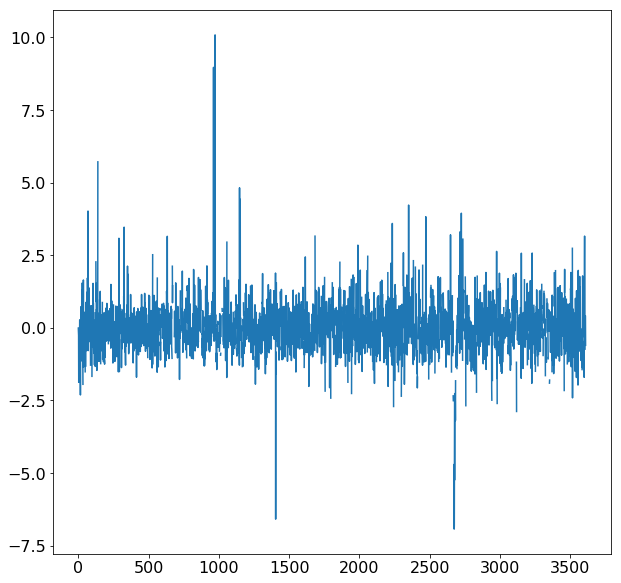

In [39]:
plt.plot(lc.corr_flux-lc.tr_time)

In [19]:
lc.tr_position

array([9863.9670376 , 9864.90879138, 9864.72539205, ..., 9863.17047495,
       9863.88761674, 9863.77394035])

In [28]:
lc.__dict__.keys()

dict_keys(['time', 'flux', 'flux_err', 'time_format', 'time_scale', 'targetid', 'label', 'meta', 'centroid_col', 'centroid_row', 'quality', 'cadenceno', 'quality_bitmask', 'channel', 'campaign', 'quarter', 'mission', 'ra', 'dec', 'pos_corr1', 'pos_corr2', 'primary_header', 'data_header', 'tr_position', 'tr_time', 'pv', 'corr_flux'])

In [52]:
to_save = ['time', 'flux', 'flux_err','centroid_col', 'centroid_row', 'quality', 'cadenceno','pos_corr1', 'pos_corr2','tr_position', 'tr_time','corr_flux']

hdu = fits.PrimaryHDU(f[0][:,:]) # can't save a masked array yet so just using pixelmap
cols = [fits.Column(name=key,format="D",array=lc.__dict__[key]) for key in to_save]
tab = fits.BinTableHDU.from_columns(cols)

hdul = fits.HDUList([hdu, tab])
hdul.writeto('%s_%s_halo_k2sc.fits' % (starname,epic),overwrite=True)


In [79]:
from halophot.halo_tools import *
def plot_k2sc(lc,image,weightmap,save_file=None,formal_name='test'):
    min_p,max_p=1./24.,20.

    PW,PH = 8.27, 11.69
    
    frequency, power, spower = get_pgram(lc.time,lc.corr_flux-lc.tr_time,min_p=min_p,max_p=max_p)
    
    rc('axes', labelsize=7, titlesize=8)
    rc('font', size=6)
    rc('xtick', labelsize=7)
    rc('ytick', labelsize=7)
    rc('lines', linewidth=1)
    fig = plt.figure(figsize=(PW,PH))
    gs1 = GridSpec(3,2)
    gs1.update(top=0.95, bottom = 2/3.*1.05,hspace=0.0,left=0.09,right=0.96)
    gs2 = GridSpec(1,2)
    gs2.update(top=2/3.*0.97,bottom=1/3.*1.07,hspace=0.35,left=0.09,right=0.96)
    gs3 = GridSpec(2,2)
    gs3.update(top=1/3.*0.96,bottom=0.04,hspace=0.07,left=0.09,right=0.96)

    ax_lctime = subplot(gs1[0,:])
    ax_lcpos = subplot(gs1[1,:],sharex=ax_lctime)
    ax_lcwhite = subplot(gs1[2,:],sharex=ax_lctime)
    ax_fluxmap = subplot(gs2[0,0])
    ax_weightmap = subplot(gs2[0,1])
    ax_periodogram   = subplot(gs3[0,:])
    ax_logpgram    = subplot(gs3[1,:])

    plot_lc(ax_lctime,lc.time,lc.flux-lc.tr_time+np.nanmedian(lc.tr_time),formal_name,trend=lc.tr_position)
    plot_lc(ax_lcpos,lc.time,lc.flux-lc.tr_position+np.nanmedian(lc.tr_position),formal_name,trend=lc.tr_time)
    plot_lc(ax_lcwhite,lc.time,lc.corr_flux-lc.tr_time,formal_name+': Whitened')
    plot_weightmap(ax_weightmap,weightmap,formal_name)
    plot_fluxmap(ax_fluxmap,image,formal_name)
    plot_pgram(ax_periodogram,frequency,power,spower,formal_name)        
    plot_log_pgram(ax_logpgram,frequency,power,spower,formal_name)  

    fig.suptitle(formal_name+' Detrended',y=0.99,fontsize=20)
    ax_periodogram.set_title('Periodograms')
    ax_fluxmap.set_title('Flux Map')
    ax_weightmap.set_title('TV-Min Weight Map')

    if save_file is not None:
        plt.savefig(save_file)
def plot_lc(ax1,time,lc,name,trend=None,title=False):
        m = (lc>0.) * (np.isfinite(lc))

        ax1.plot(time[m],lc[m]/np.nanmedian(lc[m]),'.')
        dt = np.nanmedian(time[m][1:]-time[m][:-1])
        ax1.set_xlim(time[m].min()-dt,time[m].max()+dt)
        if trend is not None:
            ax1.plot(time[m],trend[m]/np.nanmedian(trend[m]),'-',color=colours[2])
            plt.legend(labels=['Flux','Trend'])
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Relative Flux')
        if title:
            plt.title(r'%s' % name)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/halophot-0.6.6.7-py3.7.egg/halophot/halo_tools.py:675: RuntimeWarning: divide by zero encountered in log10


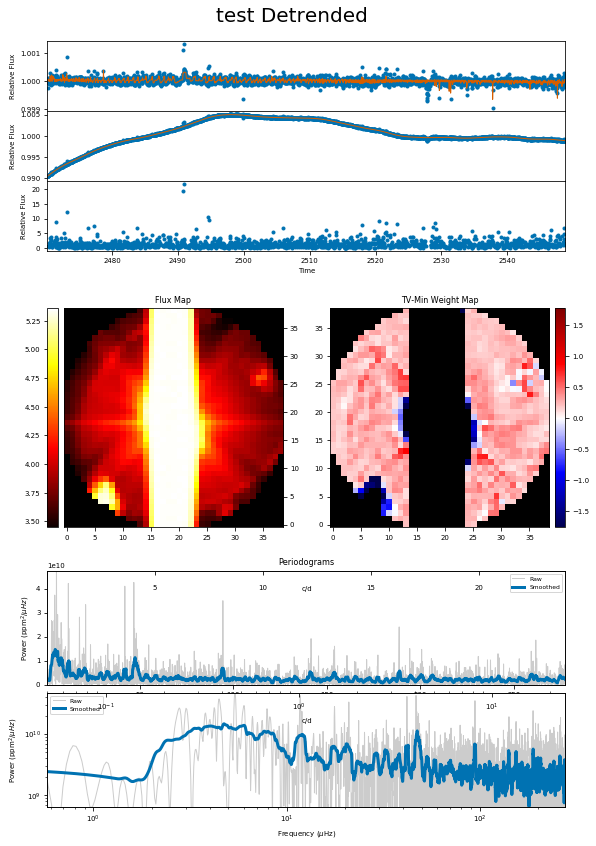

In [80]:
plot_k2sc(lc,np.nanmean(tpf.flux,axis=0),f[0][:,:].T)